Find best outer ring width so that the propagation constant matches at 1550nm

In [190]:
import numpy as np

In [191]:
import numpy as np
import matplotlib.pyplot as plt
def Plot_curve(X_arr,Y_arr,Y_legends,
                X_label,Y_label,
                title,marker_list,linestyle_list,
                text="",
                bbox_to_anchor=(),
                dpi=300):
    #Plot parameters
    figsize = (8,6)
    fonttype = "Helvetica"
    fontsize = 10
    grid_linewidth = 0.8
    plot_linewidth = 1.5
    colors_list = ['green','lightgreen',
                   'deepskyblue','lightskyblue',
                   'tomato','orange',
                   'black','red']

    plt.figure(figsize=figsize)
    for idx in range(len(Y_arr)):
        plt.plot(X_arr[idx],Y_arr[idx],label=Y_legends[idx],
                color=colors_list[idx], marker=marker_list[idx],
                linestyle=linestyle_list[idx], linewidth=plot_linewidth)
    box = {
        'facecolor': '.75',
        'edgecolor': 'r',
        'boxstyle': 'round'
    }
    # plt.
    # (0,0, 'start', bbox=box)

    plt.rcParams["font.family"] = fonttype
    plt.rcParams.update({'font.size': fontsize})
    plt.yticks(fontproperties = fonttype, size = fontsize)
    plt.xticks(fontproperties = fonttype, size = fontsize)
    plt.ticklabel_format(useOffset=False)       # 禁用变量偏移法
    plt.ylabel(Y_label, fontdict={'family' : fonttype, 'size' : fontsize})
    plt.xlabel(X_label, fontdict={'family' : fonttype, 'size' : fontsize})
    plt.title(title)
    if len(bbox_to_anchor)>0:
        plt.legend(bbox_to_anchor=bbox_to_anchor, loc='lower left', borderaxespad=0)
    else:
        plt.legend(loc='best')
    plt.grid(linewidth=grid_linewidth, alpha=0.3)
    if not text == "":
        plt.text(np.average(X_arr[0]),np.quantile(Y_arr[0], 0.25),
                text, bbox=dict(boxstyle="round,pad=0.9", fc="white", alpha=0.9))
    savename = "results/"+str(title)+".jpg"
    plt.savefig(savename,dpi=dpi)
    plt.tight_layout()
    plt.show()

In [192]:
def text_on_plot(residual,coefficients,Best_Lx):
    text = \
    "RSS = " + f"{residuals:.6f}" + "\n"\
    "Curve_fitted: y= " + "{:.2f}".format(coefficients[2]) + r"$x^2$"
    if coefficients[1] > 0:
        text = text + "+"+"{:.2f}".format(coefficients[1]) + r"$x$"
    else:
        text = text + "-"+"{:.2f}".format(-coefficients[1]) + r"$x$"
    if coefficients[0] > 0:
        text = text + "+"+"{:.2f}".format(coefficients[0]) + "\n"
    else:
        text = text + "-"+"{:.2f}".format(-coefficients[0]) + "\n"
    text = text + "Optimized Lx = " + "{:.0f}".format(Best_Lx[0]*1e3) +" nm"
    return text

In [193]:
filename = 'data/Parameter Sweep data/' + 'Scanning_Lx_from2_4to2_5um_L_inner_8um_gap.txt'
data = np.loadtxt(filename,delimiter=',',dtype=float,skiprows=1)
Lx = data[:,0]
Lx

array([2.4 , 2.41, 2.42, 2.43, 2.44, 2.45, 2.46, 2.47, 2.48, 2.49, 2.5 ])

In [194]:
n_eff = data[:,1]

# 使用polyfit进行线性拟合，deg=1表示线性拟合
coefficients = np.polyfit(Lx, n_eff, 2)

# 使用poly1d生成多项式对象
polynomial = np.poly1d(coefficients)

# 打印拟合得到的系数
print("coefficients:", coefficients)

# 使用拟合得到的模型进行预测
r_fit = np.linspace(Lx[0], Lx[-1], 100000)
n_fit = polynomial(r_fit)

coefficients: [-2.09668152e+00  5.06723142e+01  5.92146359e+03]


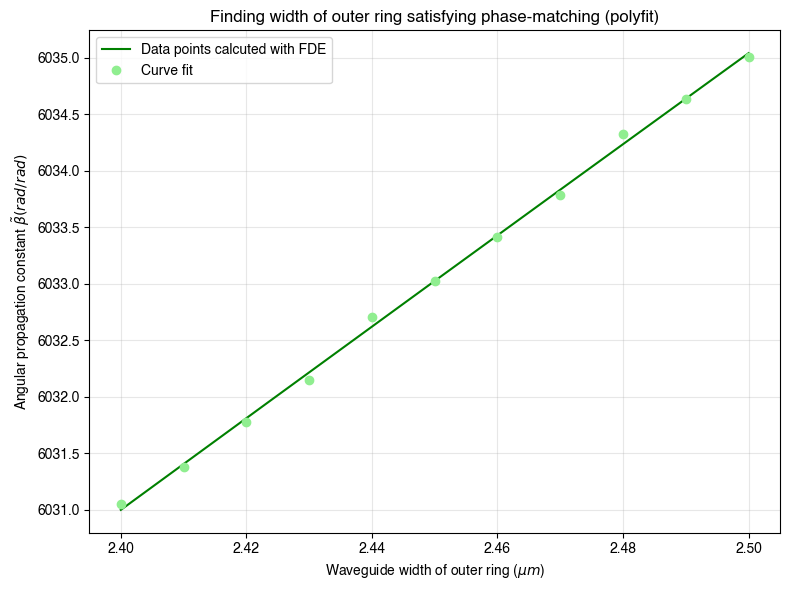

[-2.09668152e+00  5.06723142e+01  5.92146359e+03]


In [195]:
# 绘制原始数据和拟合曲线
Plot_curve((r_fit,Lx),(n_fit,n_eff),
           Y_legends = ["Data points calcuted with FDE","Curve fit"],
           X_label = r"Waveguide width of outer ring ($\mu m$)",
           Y_label = r"Angular propagation constant $\tilde{\beta}(rad/rad)$",
           title = "Finding width of outer ring satisfying phase-matching (polyfit)",
           #title = "寻找合适的波导宽度",
           marker_list = ["","o"],
           linestyle_list = ["-",""],
           bbox_to_anchor=())
print(coefficients)


In [196]:
import numpy as np
from scipy.linalg import lstsq

# 使用二次函数，最小二乘法拟合
Lx_expanded = np.c_[np.ones((np.shape(Lx)[0],1)),Lx,np.square(Lx)]
coefficients, residuals, rank, s = lstsq(Lx_expanded, n_eff)
print("最小二乘解 x:", coefficients)
print("残差平方和:", residuals)
print("矩阵 A 的秩:", rank)
print("奇异值:", s)

最小二乘解 x: [ 5.92146359e+03  5.06723142e+01 -2.09668152e+00]
残差平方和: 0.028030003242980536
矩阵 A 的秩: 3
奇异值: [2.17657797e+01 1.24853440e-01 3.74939839e-04]


In [197]:
def func(x,coefficients):
    a,b,c = coefficients
    return c*x**2+b*x+a

In [198]:
def find_best_value(x_fit,y_fit,goal):
    y_fit = y_fit - goal
    res = np.array([])
    found = False
    idx = -1
    for i in range(len(y_fit)-1):
        if found:
            idx = i
            found = False
            continue
        if y_fit[i] * y_fit[i+1] <= 0:
            found = True
            if y_fit[i] * y_fit[i+1] < 0:
                res = np.append(res,(x_fit[i]+x_fit[i+1])/2)
            elif y_fit[i] == 0:
                res = np.append(res,x_fit[i])
            else:
                res = np.append(res,x_fit[i+1])
    return res,idx


In [199]:
# Beta_Inner_ring = 5982.502609467176
Beta_Inner_ring = 6032.1966
Best_Lx,idx = find_best_value(r_fit, n_fit,Beta_Inner_ring)
n_fit[idx]

np.float64(6032.19663293458)

In [200]:
Best_Lx

array([2.4295058])

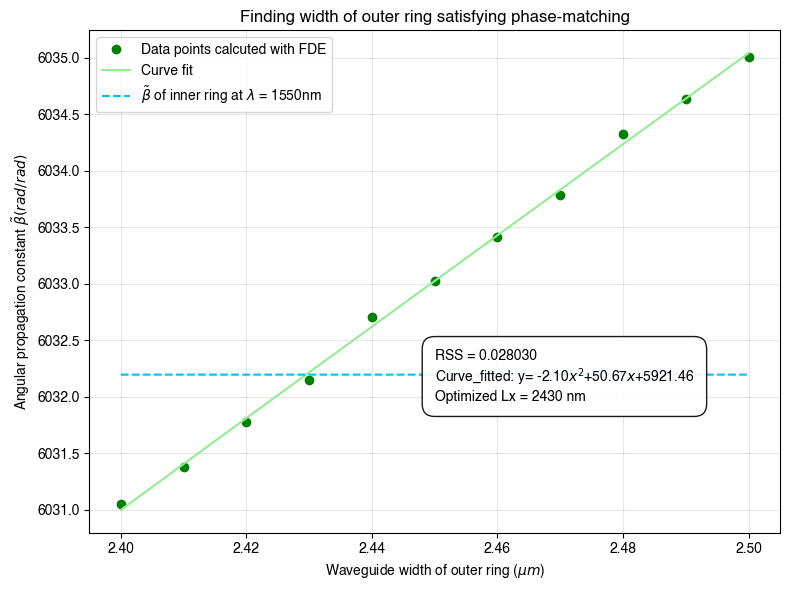

[ 5.92146359e+03  5.06723142e+01 -2.09668152e+00]


In [201]:
# 使用最小二乘法拟合的曲线
r_fit = np.linspace(Lx[0], Lx[-1], 100000)
n_fit = func(r_fit,coefficients)

text = text_on_plot(residuals,coefficients,Best_Lx)

Plot_curve((Lx,r_fit,r_fit),
           (n_eff, n_fit,np.ones(np.shape(r_fit))*Beta_Inner_ring),
           Y_legends = ["Data points calcuted with FDE",
                        "Curve fit",r"$\tilde{\beta}$ of inner ring at $\lambda$ = 1550nm"],
           X_label = r"Waveguide width of outer ring ($\mu m$)",
           Y_label = r"Angular propagation constant $\tilde{\beta}(rad/rad)$",
           title = "Finding width of outer ring satisfying phase-matching",
           #title = "寻找合适的波导宽度",
           marker_list = ["o","",""],
           linestyle_list = ["","-","--"],
           text=text,
           bbox_to_anchor=())
print(coefficients)

